# Introduction to the Keras Tuner

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/keras_tuner"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/keras_tuner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/keras_tuner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/keras_tuner.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

The Keras Tuner is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called *hyperparameter tuning* or *hypertuning*.

Hyperparameters are the variables that govern the training process and the topology of an ML model. These variables remain constant over the training process and directly impact the performance of your ML program. Hyperparameters are of two types:
1. **Model hyperparameters** which influence model selection such as the number and width of hidden layers
2. **Algorithm hyperparameters** which influence the speed and quality of the learning algorithm such as the learning rate for Stochastic Gradient Descent (SGD) and the number of nearest neighbors for a k Nearest Neighbors (KNN) classifier

In this tutorial, you will use the Keras Tuner to perform hypertuning for an image classification application.

## Setup

In [15]:
import io
import re
import string
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization


Install and import the Keras Tuner.

In [16]:
!pip install -q -U keras-tuner

In [17]:
import keras_tuner as kt

## Download and prepare the dataset

In this tutorial, you will use the Keras Tuner to find the best hyperparameters for a machine learning model that classifies images of clothing from the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

Load the data.

In [18]:
url = 'https://github.com/eyalmazuz/AttackAttributionDataset/archive/refs/heads/master.zip' 

dataset = tf.keras.utils.get_file('master.zip', url,extract=True, cache_dir='.',cache_subdir='')

In [19]:
# Normalize pixel values between 0 and 1
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 12
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master',
    batch_size=batch_size,
    validation_split=0.15,
    subset='training',
    seed=seed)

class_names = train_ds.class_names
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master',
    batch_size=batch_size,
    validation_split=0.15,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 238 files belonging to 12 classes.
Using 203 files for training.
Found 238 files belonging to 12 classes.
Using 35 files for validation.


# Text preprocessing
Next, define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize movie reviews. 

In [20]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 100000
sequence_length = 1000

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

# Define the model

When you build a model for hypertuning, you also define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a *hypermodel*.

You can define a hypermodel through two approaches:

* By using a model builder function
* By subclassing the `HyperModel` class of the Keras Tuner API

You can also use two pre-defined [HyperModel](https://keras.io/api/keras_tuner/hypermodels/) classes - [HyperXception](https://keras.io/api/keras_tuner/hypermodels/hyper_xception/) and [HyperResNet](https://keras.io/api/keras_tuner/hypermodels/hyper_resnet/) for computer vision applications.

In this tutorial, you use a model builder function to define the image classification model. The model builder function returns a compiled model and uses hyperparameters you define inline to hypertune the model.

In [21]:
min_embedding_dim=16
max_embedding_dim=1024

min_vocab_size = 10000
max_vocab_size = 1000000

def model_builder(hp):
  model = keras.Sequential()
  model.add(vectorize_layer)
  hp_units_embed = hp.Int('units_emb_1', min_value=min_embedding_dim, max_value=max_embedding_dim, step=32)
  model.add(Embedding(100000, output_dim= hp_units_embed, name="embedding"))
  model.add(GlobalAveragePooling1D())
 
  # # Tune the number of layers. Best to do it manually for now
  # for i in range(hp.Int("num_layers", 1, 3)):
  #     model.add(
  #         layers.Dense(
  #             # Tune number of units separately.
  #             units=hp.Int(f"units_{i}", min_value=382, max_value=512, step=32),
  #             activation=hp.Choice("activation", ["relu", "tanh"]),
  #         )
  #     )


  # Tune the number of units in the first Dense layer + the activation function
  # Choose an optimal value between 32-512
  hp_units_1 = hp.Int('units_dense_1', min_value=200, max_value=1024, step=20)
  hp_units_2 = hp.Int('units_dense_2', min_value=58, max_value=512, step=15)
  hp_units_3 = hp.Int('units_dense_3', min_value=32, max_value=250, step=15)
  hp_units_4 = hp.Int('units_dense_4', min_value=12, max_value=100, step=15)
  hp_drop_1 = hp.Choice('units_drop_1', values=[0.01, 0.05, 0.1,0.15, 0.2, 0.25, 0.3])
  hp_drop_2 = hp.Choice('units_drop_2', values=[0.01, 0.05, 0.1,0.15, 0.2, 0.25, 0.3])


  model.add(keras.layers.Dense(units=hp_units_1, activation= hp.Choice("activation_1", ["relu", "tanh"])))
  model.add(Dense(units=hp_units_2, activation=hp.Choice("activation_2", ["relu", "tanh"])))
  model.add(tf.keras.layers.Dropout(hp_drop_1)) 
  model.add(Dense(units=hp_units_3, activation=hp.Choice("activation_3", ["relu", "tanh"])))
  model.add(tf.keras.layers.Dropout(hp_drop_2))
  model.add(Dense(units=hp_units_4, activation=hp.Choice("activation_4", ["relu", "tanh"])))
  model.add(Dense(len(class_names)))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.005,  0.0011, 0.001,0.0009, 0.0005, 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1.1e-3, 9e-4, 5e-4, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hypertuning

Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`. In this tutorial, you use the [Hyperband](https://arxiv.org/pdf/1603.06560.pdf) tuner.

To instantiate the Hyperband tuner, you must specify the hypermodel, the `objective` to optimize and the maximum number of epochs to train (`max_epochs`).

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + log<sub>`factor`</sub>(`max_epochs`) and rounding it up to the nearest integer.

Create a callback to stop training early after reaching a certain value for the validation loss.

In [23]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early_val_accuracy = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

Run the hyperparameter search. The arguments for the search method are the same as those used for `tf.keras.model.fit` in addition to the callback above.

In [24]:
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyper parameters for the model are: {best_hps.values}")
print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is {best_hps.get('units_dense_1')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.""")

Best Hyper parameters for the model are: {'units_emb_1': 848, 'units_dense_1': 440, 'units_dense_2': 223, 'units_dense_3': 122, 'units_dense_4': 72, 'units_drop_1': 0.1, 'units_drop_2': 0.15, 'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'tanh', 'activation_4': 'relu', 'learning_rate': 0.0009, 'tuner/epochs': 15, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is 440 and the optimal learning rate for the optimizer is 0.0009.


## Train the model

Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [25]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
17/17 [==============================] - 2s 65ms/step - loss: 2.4425 - accuracy: 0.2020 - val_loss: 2.4592 - val_accuracy: 0.1429
Epoch 2/50
17/17 [==============================] - 1s 51ms/step - loss: 2.2846 - accuracy: 0.2463 - val_loss: 2.4541 - val_accuracy: 0.1429
Epoch 3/50
17/17 [==============================] - 1s 53ms/step - loss: 2.1125 - accuracy: 0.2463 - val_loss: 2.3446 - val_accuracy: 0.1429
Epoch 4/50
17/17 [==============================] - 1s 56ms/step - loss: 1.7968 - accuracy: 0.3350 - val_loss: 2.3081 - val_accuracy: 0.1714
Epoch 5/50
17/17 [==============================] - 1s 57ms/step - loss: 1.4680 - accuracy: 0.5123 - val_loss: 2.3766 - val_accuracy: 0.1429
Epoch 6/50
17/17 [==============================] - 1s 57ms/step - loss: 1.0882 - accuracy: 0.6305 - val_loss: 2.0178 - val_accuracy: 0.2857
Epoch 7/50
17/17 [==============================] - 1s 55ms/step - loss: 0.7306 - accuracy: 0.7685 - val_loss: 2.0942 - val_accuracy: 0.3429
Epoch 8/50
17

Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [26]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(train_ds, epochs=best_epoch, validation_data=val_ds)

Epoch 1/33
17/17 [==============================] - 2s 61ms/step - loss: 2.4367 - accuracy: 0.2020 - val_loss: 2.4220 - val_accuracy: 0.1429
Epoch 2/33
17/17 [==============================] - 1s 51ms/step - loss: 2.2946 - accuracy: 0.2463 - val_loss: 2.4023 - val_accuracy: 0.1714
Epoch 3/33
17/17 [==============================] - 1s 52ms/step - loss: 2.0868 - accuracy: 0.2463 - val_loss: 2.3191 - val_accuracy: 0.2000
Epoch 4/33
17/17 [==============================] - 1s 52ms/step - loss: 1.7532 - accuracy: 0.3744 - val_loss: 2.1850 - val_accuracy: 0.2571
Epoch 5/33
17/17 [==============================] - 1s 52ms/step - loss: 1.4205 - accuracy: 0.4877 - val_loss: 2.1593 - val_accuracy: 0.2571
Epoch 6/33
17/17 [==============================] - 1s 51ms/step - loss: 1.1372 - accuracy: 0.5764 - val_loss: 2.1560 - val_accuracy: 0.2857
Epoch 7/33
17/17 [==============================] - 1s 51ms/step - loss: 0.8435 - accuracy: 0.6995 - val_loss: 2.1076 - val_accuracy: 0.3714
Epoch 8/33
17

## Plot Model Accuracy and Loss




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [2.4367334842681885, 2.2946465015411377, 2.0868124961853027, 1.7532169818878174, 1.420462965965271, 1.1371691226959229, 0.8434509038925171, 0.6245474219322205, 0.42255541682243347, 0.2530214786529541, 0.16976551711559296, 0.13051459193229675, 0.2224455624818802, 0.13723386824131012, 0.09413956850767136, 0.04447036609053612, 0.03497203439474106, 0.01748112216591835, 0.019978675991296768, 0.02273428812623024, 0.018331892788410187, 0.026861991733312607, 0.014038399793207645, 0.017149731516838074, 0.010469889268279076, 0.011057241819798946, 0.010965872555971146, 0.010529299266636372, 0.010753250680863857, 0.008722612634301186, 0.015285272151231766, 0.00338088721036911, 0.019650625064969063], 'accuracy': [0.2019704431295395, 0.2463054209947586, 0.2463054209947586, 0.37438422441482544, 0.4876847267150879, 0.5763546824455261, 0.6995074152946472, 0.802955687046051, 0.8620689511299133, 0.935960590839386, 0.9507389068603516, 0.

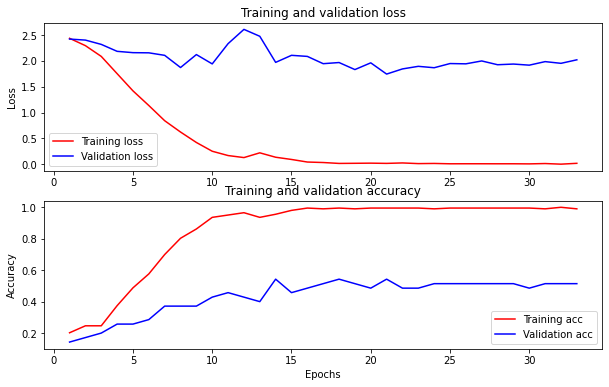

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())
print(history_dict)

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Model Metrics

In [28]:
# Model Metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np

y_labels = val_ds.map(lambda x,y: y)
print(y_labels.unbatch)

y_labels = y_labels.as_numpy_iterator()

## Reduce to 1D Array
y_labels = np.concatenate([y for x, y in val_ds], axis=0)

y_hat_probs = hypermodel.predict(val_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)


## accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_labels, y_hat_classes)
print('Accuracy: %f' % accuracy)

## precision tp / (tp + fp)
precision = precision_score(y_labels, y_hat_classes, average=None)
print('Precision (None): %f' % precision.sum())
precision = precision_score(y_labels, y_hat_classes, average='micro')
print('Precision (micro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'macro')
print('Precision (macro): %f' % precision)
# precision = precision_score(y_labels, y_hat_classes, average= 'samples')
# print('Precision (samples): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'weighted')
print('Precision (weighted): %f' % precision)

## recall: tp / (tp + fn)
recall = recall_score(y_labels, y_hat_classes, average='micro')
print('Recall (micro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='macro')
print('Recall (macro): %f' % recall)
# recall = recall_score(y_labels, y_hat_classes, average='samples')
# print('Recall (samples): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='weighted')
print('Recall (weighted): %f' % recall)

## f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_labels, y_hat_classes, average='micro')
print('F1 score (micro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='macro')
print('F1 score (macro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='weighted')
print('F1 score (weighted): %f' % f1)
 
## kappa
kappa = cohen_kappa_score(y_labels, y_hat_classes)
print('Cohens kappa: %f' % kappa)

## ROC AUC
# print(np.sum(y_hat_probs))
# y_hat_probs = y_hat_probs / np.sum(y_hat_probs)
# print(np.sum(y_hat_probs))
# auc = roc_auc_score(y_labels, y_hat_probs, multi_class='ovo')
# print('ROC AUC: %f' % auc)

## confusion matrix
matrix = confusion_matrix(y_labels, y_hat_classes)
print(matrix)

<bound method DatasetV2.unbatch of <MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>>
Accuracy: 0.514286
Precision (None): 7.205556
Precision (micro): 0.514286
Precision (macro): 0.600463
Precision (weighted): 0.590952
Recall (micro): 0.514286
Recall (macro): 0.522222
Recall (weighted): 0.514286
F1 score (micro): 0.514286
F1 score (macro): 0.504714
F1 score (weighted): 0.506811
Cohens kappa: 0.454128
[[1 0 0 0 0 0 1 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 2 0 0 0 2 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 2 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 1]]


The `my_dir/intro_to_kt` directory contains detailed logs and checkpoints for every trial (model configuration) run during the hyperparameter search. If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, pass an additional `overwrite=True` argument while instantiating the tuner.

## Summary

In this tutorial, you learned how to use the Keras Tuner to tune hyperparameters for a model. To learn more about the Keras Tuner, check out these additional resources:

* [Keras Tuner on the TensorFlow blog](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html)
* [Keras Tuner website](https://keras-team.github.io/keras-tuner/)

Also check out the [HParams Dashboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams) in TensorBoard to interactively tune your model hyperparameters.